In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from nltk.metrics import edit_distance

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


False

In [5]:
def prepare_text(raw_text):
    """Preprocesses the text with tokenization, case folding, stemming, and lemmatization
    """
    # Convert text to lowercase (case folding)
    text = raw_text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Apply stemming and lemmatization
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens]

    return tokens


result = prepare_text("Edvard was a Runner. He was always running.")
print(result)

['edvard', 'runner', 'alway', 'run']


In [6]:
def get_stop_words(dataset):
    """Detects stop-words
    """
    # Combine all texts into a single string
    all_text = " ".join(dataset).lower()

    # Tokenize the combined text
    tokens = word_tokenize(all_text)

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Count term frequencies
    term_frequencies = Counter(tokens)

    # Sort terms by frequency in descending order and return the top repetitive terms
    top_terms = dict(term_frequencies.most_common(50))  # Adjust the number as needed

    return top_terms

In [7]:
def remove_stop_words(raw_text, freq):
    words_to_remove=[]
    for i,d in enumerate(freq):
        words_to_remove.append(d)
        if i == 5:
            break
    result = [i for i in raw_text if i not in words_to_remove]
    
    return result

In [8]:
dataset = pd.read_csv('english_dataset.csv')

In [9]:
dataset

,Unnamed: 0,title,text
0,0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello..."
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...
2,2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...
3,3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T..."
4,4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...
...,...,...,...
6330,6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...
6331,6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332,6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...
6333,6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene..."


In [10]:
def get_text(dataset, limit):

    res = []
    for i, d in enumerate(dataset['text']): 
        res.append(prepare_text(d))
        if i == limit - 1:  # Process only up to the limit
            break
    return res

In [11]:
processed_texts = get_text(dataset, limit=10)


In [12]:
stop_words = get_stop_words([" ".join(text) for text in processed_texts])

In [13]:
removed_stop_words = remove_stop_words(processed_texts[0], stop_words)


In [14]:
print(stop_words)

{'’': 149, 'trump': 91, '“': 90, '”': 90, 'clinton': 64, 'said': 39, 'veteran': 36, 'time': 34, 'fbi': 31, 'support': 29, 'hillari': 28, 'war': 28, 'would': 25, 'u.s.': 25, 'one': 23, 'state': 23, 'presid': 22, '—': 22, 'va': 22, 'obama': 21, 'iran': 20, 'new': 19, 'want': 19, 'american': 19, 'iraq': 19, 'claim': 18, 'could': 18, 'countri': 18, 'care': 18, 'go': 17, 'year': 17, 'offici': 16, 'republican': 14, 'day': 14, 'way': 13, 'plan': 13, 'campaign': 13, 'problem': 13, 'york': 12, 'elect': 12, 'peopl': 12, 'start': 12, 'democrat': 12, 'also': 12, 'say': 12, 'march': 12, 'nation': 12, 'america': 12, 'militari': 12, 'forc': 12}


In [15]:
def build_positional_index(documents):
  
    positional_index = defaultdict(lambda: defaultdict(list))
    for doc_id, doc in enumerate(documents):
        for pos, term in enumerate(doc):
            positional_index[term][doc_id].append(pos)
    return positional_index

In [16]:
def build_bigram_index(vocabulary):
    
    bigram_index = defaultdict(list)
    for term in vocabulary:
        padded_term = f"${term}$"
        bigrams = [padded_term[i:i+2] for i in range(len(padded_term) - 1)]
        for bigram in bigrams:
            bigram_index[bigram].append(term)
    return bigram_index

In [17]:
import pickle
def save_index(index, filename):
    # Convert all nested defaultdicts to regular dicts before saving
    def convert_to_dict(obj):
        if isinstance(obj, defaultdict):
            return {key: convert_to_dict(value) for key, value in obj.items()}
        return obj

    index = convert_to_dict(index)
    with open(filename, 'wb') as f:
        pickle.dump(index, f)


In [18]:
positional_index = build_positional_index(processed_texts)


In [19]:
vocabulary = set(term for doc in processed_texts for term in doc)
bigram_index = build_bigram_index(vocabulary)

In [20]:
save_index(positional_index, "positional_index.pkl")
save_index(bigram_index, "bigram_index.pkl")

In [21]:
def load_index(filename):

    with open(filename, 'rb') as f:
        return pickle.load(f)

In [22]:
loaded_positional_index = load_index("positional_index.pkl")
loaded_bigram_index = load_index("bigram_index.pkl")

In [23]:
print("Positional Index:", loaded_positional_index)
print("Bigram Index:", loaded_bigram_index)

Positional Index: {'daniel': {0: [0]}, 'greenfield': {0: [1]}, 'shillman': {0: [2]}, 'journal': {0: [3]}, 'fellow': {0: [4], 5: [139, 695, 939, 1144]}, 'freedom': {0: [5], 5: [39, 68]}, 'center': {0: [6], 8: [900, 971, 1022]}, 'new': {0: [7, 131, 564], 3: [43], 4: [3, 38, 73, 141, 187], 5: [7, 14, 746, 971, 1004], 8: [171, 1352], 9: [22, 55, 427]}, 'york': {0: [8, 132], 3: [44], 4: [4, 39, 74, 142, 188], 5: [8], 8: [172], 9: [23, 428]}, 'writer': {0: [9]}, 'focus': {0: [10, 442, 496], 5: [1012]}, 'radic': {0: [11], 8: [1340]}, 'islam': {0: [12], 5: [657, 706, 748, 754]}, 'final': {0: [13, 431], 5: [566], 6: [159], 9: [18, 67]}, 'stretch': {0: [14, 195]}, 'elect': {0: [15, 29, 64, 278, 691], 1: [142, 219, 224], 3: [115, 229], 4: [161], 8: [1136]}, 'hillari': {0: [16, 44, 61, 70, 105, 118, 252, 258, 271, 326, 339, 350, 359, 408, 466, 474, 594, 684], 3: [50, 108, 123, 181, 232], 4: [6, 169, 175, 179], 8: [0]}, 'rodham': {0: [17]}, 'clinton': {0: [18, 86, 116, 119, 272, 351, 398, 409, 467,

In [24]:
def gamma_encode(numbers):
    
    encoded = ""
    for number in numbers:
        binary = bin(number)[2:]  # Binary representation without '0b'
        offset = binary[1:]  # Remove the leading '1'
        length = '1' * len(offset) + '0'  # Unary representation of length
        encoded += length + offset
    return encoded


In [25]:
def variable_byte_encode(numbers):
    
    encoded = []
    for number in numbers:
        bytes_ = []
        while True:
            bytes_.insert(0, number % 128)  # Take the last 7 bits
            if number < 128:
                break
            number //= 128
        bytes_[-1] += 128  # Mark the end of the number
        encoded.extend(bytes_)
    return bytes(encoded)

In [26]:
def store_index(path, compression_type, index):
    compressed_index = {}
    if compression_type == "gamma-code":
        for term, postings in index.items():
            compressed_index[term] = {doc_id: gamma_encode(positions) for doc_id, positions in postings.items()}
    elif compression_type == "variable-byte":
        for term, postings in index.items():
            compressed_index[term] = {doc_id: variable_byte_encode(positions) for doc_id, positions in postings.items()}
    else:  # no-compression
        compressed_index = index

    with open(path, 'wb') as f:
        pickle.dump(compressed_index, f)

    return len(pickle.dumps(compressed_index))


In [27]:
def load_index(path, compression_type):
   
    with open(path, 'rb') as f:
        compressed_index = pickle.load(f)

    if compression_type == "gamma-code":
        # Decompression logic for gamma coding (not implemented here)
        pass
    elif compression_type == "variable-byte":
        # Decompression logic for variable byte coding (not implemented here)
        pass

    return compressed_index

In [28]:
size_of_file = store_index("positional_index_gamma.pkl", "gamma-code", positional_index)
print(f"Size of stored file (Gamma coding): {size_of_file} bytes")


Size of stored file (Gamma coding): 121726 bytes


In [29]:
loaded_index = load_index("positional_index_gamma.pkl", "gamma-code")
print("Loaded Index:", loaded_index)

Loaded Index: {'daniel': {0: '0'}, 'greenfield': {0: '0'}, 'shillman': {0: '100'}, 'journal': {0: '101'}, 'fellow': {0: '11000', 5: '11111110000101111111111100101101111111111110110101011111111111100001111000'}, 'freedom': {0: '11001', 5: '111110001111111110000100'}, 'center': {0: '11010', 8: '111111111011000010011111111101110010111111111110111111110'}, 'new': {0: '110111111111000000111111111110000110100', 3: '11111001011', 4: '101111110001101111110001001111111100001101111111100111011', 5: '110111110110111111111001110101011111111101110010111111111110111101100', 8: '111111100101011111111111100101001000', 9: '1111001101111101011111111111010101011'}, 'york': {0: '1110000111111100000100', 3: '11111001100', 4: '11000111110001111111110001010111111100001110111111100111100', 5: '1110000', 8: '111111100101100', 9: '11110011111111111010101100'}, 'writer': {0: '1110001'}, 'focus': {0: '11100101111111101011101011111111011110000', 5: '1111111110111110100'}, 'radic': {0: '1110011', 8: '11111111110010

In [30]:
def calculate_jaccard_similarity(query_bigrams, term_bigrams):
   
    intersection = len(query_bigrams & term_bigrams)
    union = len(query_bigrams | term_bigrams)
    return intersection / union if union != 0 else 0


In [31]:
def get_best_match(candidates, misspelled_word):
   
    return min(candidates, key=lambda word: edit_distance(misspelled_word, word))


In [32]:
def create_bigram_index(vocabulary):
    
    return build_bigram_index(vocabulary)

In [33]:
def get_corrected_text(raw_text, bigram_index):

    tokens = prepare_text(raw_text)
    corrected_tokens = []

    for token in tokens:
        padded_token = f"${token}$"
        token_bigrams = set([padded_token[i:i+2] for i in range(len(padded_token) - 1)])

        # Find candidate words
        candidates = set()
        for bigram in token_bigrams:
            if bigram in bigram_index:
                candidates.update(bigram_index[bigram])

        # Calculate Jaccard similarity for candidates
        jaccard_scores = {
            candidate: calculate_jaccard_similarity(token_bigrams, set(f"${candidate}$"[i:i+2] for i in range(len(f"${candidate}$") - 1)))
            for candidate in candidates
        }

        # Filter top candidates by Jaccard similarity
        top_candidates = sorted(jaccard_scores, key=jaccard_scores.get, reverse=True)[:5]

        # Choose the best match using edit distance
        best_match = get_best_match(top_candidates, token) if top_candidates else token
        corrected_tokens.append(best_match)

    return " ".join(corrected_tokens)


In [34]:
vocabulary = ["hello", "hell", "herlock", "sherlock", "holmes", "adventure", "adventures"]
bigram_index = create_bigram_index(vocabulary)
corrected_text = get_corrected_text("the adevntures of herlock holmes", bigram_index)
print("Corrected Text:", corrected_text)

Corrected Text: adventure herlock holmes


In [35]:
#Second phase 

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from collections import Counter, defaultdict
import pandas as pd
import pickle
import json
import math
from nltk.metrics import edit_distance
import os

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


False

In [36]:
class LanguageModel:
    """Models prior probability of unigrams and bigrams."""

    def __init__(self, corpus_dir='MIR2-data/corpus', lambda_=0.1):
        """Iterates over all whitespace-separated tokens in each file in
        `corpus_dir`, and counts the number of occurrences of each unigram and
        bigram. Also keeps track of the total number of tokens in the corpus.

        Args:
            corpus_dir (str): Path to directory containing corpus.
            lambda_ (float): Interpolation factor for smoothing by unigram-bigram
                interpolation. You only need to save `lambda_` as an attribute for now, and
                it will be used later in `LanguageModel.get_bigram_logp`. See Section
                IV.1.2. below for further explanation.
        """
        self.lambda_ = lambda_
        self.total_num_tokens = 0        # Counts total number of tokens in the corpus
        self.unigram_counts = Counter()  # Maps strings w_1 -> count(w_1)
        self.bigram_counts = Counter()   # Maps tuples (w_1, w_2) -> count((w_1, w_2))

        # Iterate through all files in the corpus directory
        for filename in os.listdir(corpus_dir):
            file_path = os.path.join(corpus_dir, filename)
            if os.path.isfile(file_path):
                with open(file_path, 'r', encoding='utf-8') as file:
                    for line in file:
                        tokens = word_tokenize(line.lower())  # Tokenize and lowercase
                        self.total_num_tokens += len(tokens)
                        self.unigram_counts.update(tokens)
                        self.bigram_counts.update(zip(tokens[:-1], tokens[1:]))

    def get_unigram_prob(self, word):
        """Calculates the MLE unigram probability of a word.

        Args:
            word (str): The unigram whose probability is to be calculated.

        Returns:
            float: The unigram probability.
        """
        return self.unigram_counts[word] / self.total_num_tokens if self.total_num_tokens > 0 else 0.0

    def get_unigram_logp(self, unigram):
        """Computes the log-probability of `unigram` under this `LanguageModel`.

        Args:
            unigram (str): Unigram for which to compute the log-probability.

        Returns:
            log_p (float): Log-probability of `unigram` under this `LanguageModel`.
        """
        prob = self.get_unigram_prob(unigram)
        return math.log(prob) if prob > 0 else float('-inf')

    def get_bigram_logp(self, w_1, w_2):
        """Computes the log-probability of `bigram` under this `LanguageModel`.

        Note:
            Use self.lambda_ for the unigram-bigram interpolation factor.

        Args:
            w_1 (str): First word in bigram.
            w_2 (str): Second word in bigram.

        Returns:
            log_p (float): Log-probability of `bigram` under this `LanguageModel`.
        """
        unigram_prob = self.get_unigram_prob(w_2)
        bigram_count = self.bigram_counts[(w_1, w_2)]
        w1_count = self.unigram_counts[w_1]

        bigram_prob = (bigram_count / w1_count) if w1_count > 0 else 0.0
        interpolated_prob = self.lambda_ * unigram_prob + (1 - self.lambda_) * bigram_prob
        return math.log(interpolated_prob) if interpolated_prob > 0 else float('-inf')

    def get_query_logp(self, query):
        """Computes the log-probability of `query` under this `LanguageModel`.

        Args:
            query (str): Whitespace-delimited sequence of terms in the query.

        Returns:
            log_p (float): Log-probability assigned to the query under this
                `LanguageModel`.
        """
        tokens = word_tokenize(query.lower())
        if not tokens:
            return float('-inf')

        log_prob = self.get_unigram_logp(tokens[0])
        for i in range(1, len(tokens)):
            log_prob += self.get_bigram_logp(tokens[i - 1], tokens[i])

        return log_prob


In [37]:
# Make sure your implementation passes the following sanity checks
# Note: Constructing the language model could take 30 seconds or longer
# We suggest using `tqdm` to track progress in your `LanguageModel.__init__` function.
lm = LanguageModel()

print('num. unigrams("{}")'.format(len(lm.unigram_counts))) 
print('num. bigrams("{}")'.format(len(lm.bigram_counts)))
print('num. tokens("{}")'.format(lm.total_num_tokens))


# Test a reasonable query with and without typos (you should try your own)!
query_wo_typo = "sharif university" # write a query without typo
query_w_typo = "sharaf universit"  # write a query with typo

p_wo_typo = math.exp(lm.get_query_logp(query_wo_typo))
p_w_typo = math.exp(lm.get_query_logp(query_w_typo))
print('P("{}") == {}'.format(query_wo_typo, p_wo_typo))
print('P("{}") == {}'.format(query_w_typo, p_w_typo))
if p_wo_typo <= p_w_typo:
    print('Are you sure "{}" should be assigned higher probability than "{}"?'
          .format(query_w_typo, query_wo_typo))
    
print("done!")


num. unigrams("335917")
num. bigrams("4415665")
num. tokens("25626660")
P("sharif university") == 6.327068411614059e-07
P("sharaf universit") == 0.0
done!


In [38]:
class BaseEditProbabilityModel:
    def get_edit_logp(self, edited, original):
       
        raise NotImplementedError  # Force subclass to implement this method

from nltk.metrics.distance import edit_distance as nltk_edit_distance

class EditProbabilityModel(BaseEditProbabilityModel):
    def __init__(self, insertion_cost=1, deletion_cost=1, substitution_cost=1, transposition_cost=1):
        """Initializes the edit probability model with costs for different operations.

        Args:
            insertion_cost (int): Cost for inserting a character.
            deletion_cost (int): Cost for deleting a character.
            substitution_cost (int): Cost for substituting a character.
            transposition_cost (int): Cost for transposing two characters.
        """
        self.insertion_cost = insertion_cost
        self.deletion_cost = deletion_cost
        self.substitution_cost = substitution_cost
        self.transposition_cost = transposition_cost

    def get_edit_logp(self, edited, original):
        """Computes the log-probability of editing `original` to `edited`.

        Args:
            edited (str): Edited term.
            original (str): Original term.

        Returns:
            logp (float): Log-probability of the edit.
        """
        # Use basic edit distance (without specific costs) from NLTK
        dist = nltk_edit_distance(original, edited, transpositions=True)
        
        # Return the negative edit distance as the log-probability
        return -dist



In [39]:

epm = EditProbabilityModel()
original = 'user'
edited = 'usre'
score = epm.get_edit_logp(edited, original)
print(f"Edit log-probability: {score}")


Edit log-probability: -1


In [40]:
class UniformEditProbabilityModel(BaseEditProbabilityModel):
    def __init__(self, edit_prob=0.05):
        """
        Args:
            edit_prob (float): Probability of a single edit occurring, where
                an edit is an insertion, deletion, substitution, or transposition,
                as defined by the Damerau-Levenshtein distance.
        """
        self.edit_prob = edit_prob

    def get_edit_logp(self, edited, original):
        """Gets the log-probability of editing `original` to arrive at `edited`.

        Args:
            edited (str): Edited term.
            original (str): Original term.

        Returns:
            logp (float): Log-probability of `edited` given `original`.
        """
        if edited == original:
            return math.log(1 - self.edit_prob)  # High probability for no edit
        else:
            return math.log(self.edit_prob)  # Uniform probability for a single edit


In [41]:
class CandidateGenerator:
    # Alphabet to use for insertion and substitution
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                ' ', ',', '.', '-']

    def __init__(self, lm, epm):
        """
        Args:
            lm (LanguageModel): Language model to use for prior probabilities, P(Q).
            epm (EditProbabilityModel): Edit probability model to use for P(R|Q).
        """
        self.lm = lm
        self.epm = epm

    def get_num_oov(self, query):
        """Get the number of out-of-vocabulary (OOV) words in `query`."""
        return sum(1 for w in query.strip().split()
                   if w not in self.lm.unigram_counts)

    def filter_and_yield(self, query, lp):
        if query.strip() and self.get_num_oov(query) == 0:
            yield query, lp

    def generate_edits(self, term):
        """Generates all edits of distance one for a given term."""
        edits = set()
        for i in range(len(term) + 1):
            # Insertions
            for c in self.alphabet:
                edits.add(term[:i] + c + term[i:])
            if i < len(term):
                # Deletions
                edits.add(term[:i] + term[i + 1:])
                # Substitutions
                for c in self.alphabet:
                    edits.add(term[:i] + c + term[i + 1:])
        for i in range(len(term) - 1):
            # Transpositions
            edits.add(term[:i] + term[i + 1] + term[i] + term[i + 2:])
        return edits

    def get_candidates(self, query):
        """Starts from `query`, and performs EDITS OF DISTANCE <=2 to get new
        candidate queries. To make scoring tractable, only returns/yields
        candidates that satisfy certain criteria."""
        yield from self.filter_and_yield(query, self.epm.get_edit_logp(query, query))

        terms = query.split()
        for i, term in enumerate(terms):
            edits = self.generate_edits(term)
            for edit in edits:
                if edit in self.lm.unigram_counts:
                    new_query = terms[:i] + [edit] + terms[i + 1:]
                    yield from self.filter_and_yield(" ".join(new_query), self.epm.get_edit_logp(edit, term))


In [42]:

lm = LanguageModel(corpus_dir='MIR2-data/corpus')
epm = UniformEditProbabilityModel()
cg = CandidateGenerator(lm, epm)
query = 'sharif university'
num_candidates = 0
did_generate_original = False
for candidate, candidate_logp in cg.get_candidates(query):
    num_candidates += 1
    if candidate == query:
        did_generate_original = True

print(num_candidates)
print(did_generate_original)

50
True


In [43]:
class CandidateScorer:
    """Combines the `LanguageModel`, `EditProbabilityModel`, and
    `CandidateGenerator` to produce the most likely query Q given a raw query R.
    Since the candidate generator already uses the edit probability model, we
    do not need to take the edit probability model as an argument in the constructor.
    """
    def __init__(self, lm, cg, mu=1.0):
        """
        Args:
            lm (LanguageModel): Language model for estimating P(Q).
            cg (CandidateGenerator): Candidate generator for generating possible Q.
            mu (float): Weighting factor for the language model (see write-up).
                Remember that our probability computations are done in log-space.
        """
        self.lm = lm
        self.cg = cg
        self.mu = mu

    def get_score(self, query, log_edit_prob):
        """Uses the language model and `log_edit_prob` to compute the final
        score for a candidate `query`. Uses `mu` as weighting exponent for P(Q).

        Args:
            query (str): Candidate query.
            log_edit_prob (float): Log-probability of candidate query given
                original query (i.e., log(P(R|Q), where R is `query`).

        Returns:
            log_p (float): Final score for the query, i.e., the log-probability
                of the query.
        """
        log_pq = self.lm.get_query_logp(query)
        return log_edit_prob + self.mu * log_pq

    def correct_spelling(self, r):
        """Corrects spelling of raw query `r` to get the intended query `q`.

        Args:
            r (str): Raw input query from the user.

        Returns:
            q (str): Spell-corrected query. That is, the query that maximizes
                P(R|Q)*P(Q) under the language model and edit probability model,
                restricted to Q's generated by the candidate generator.
        """
        candidates = self.cg.get_candidates(r)
        best_score = float('-inf')
        best_candidate = r

        for candidate, log_edit_prob in candidates:
            score = self.get_score(candidate, log_edit_prob)
            if score > best_score:
                best_score = score
                best_candidate = candidate

        return best_candidate

In [44]:
# Assumes LanguageModel lm was already built above
print('Building edit probability model...')
epm = UniformEditProbabilityModel()
print('Building candidate generator...')
cg = CandidateGenerator(lm, epm)
print('Building candidate scorer model...')
cs = CandidateScorer(lm, cg, mu=1.0)
print('Running spelling corrector...')

# Add your own queries here to test your spelling corrector
queries = [('sharaf university', ' sharif university'),
           ('sharif university', ' sharif university')
           ]
for query, expected in queries:
    corrected = cs.correct_spelling(query)
    print("\t'{}' corrected to '{}'".format(query, corrected))


Building edit probability model...
Building candidate generator...
Building candidate scorer model...
Running spelling corrector...
	'sharaf university' corrected to 'sharif university'
	'sharif university' corrected to 'sharif university'


In [45]:
def dev_eval(candidate_scorer, verbose=False):
    """Evaluate `candidate_scorer` on the dev set."""
    query_num = 1
    yours_correct = 0
    google_correct = 0
    # Read originals, ground-truths, Google's predictions
    dev_dir = 'MIR2-data/dev_set/'
    with tqdm(total=455, unit=' queries') as pbar, \
            open(os.path.join(dev_dir, 'queries.txt'), 'r') as query_fh, \
            open(os.path.join(dev_dir, 'gold.txt'), 'r') as gold_fh, \
            open(os.path.join(dev_dir, 'google.txt'), 'r') as google_fh:
        while True:
            # Read one line
            query = query_fh.readline().rstrip('\n')
            if not query:
                # Finished all queries
                break
            corrected = candidate_scorer.correct_spelling(query)
            corrected = ' '.join(corrected.split())  # Squash multiple spaces
            gold = gold_fh.readline().rstrip('\n')
            google = google_fh.readline().rstrip('\n')

            # Count whether correct
            if corrected == gold:
                yours_correct += 1
            if google == gold:
                google_correct += 1

            # Print running stats
            yours_accuracy = yours_correct / query_num * 100
            google_accuracy = google_correct / query_num * 100
            if verbose:
                print('QUERY {:03d}'.format(query_num))
                print('---------')
                print('(original):      {}'.format(query))
                print('(corrected):     {}'.format(corrected))
                print('(google):        {}'.format(google))
                print('(gold):          {}'.format(gold))
                print('Google accuracy: {}/{} ({:5.2f}%)\n'
                      .format(google_correct, query_num, google_accuracy))
                print('Your accuracy:   {}/{} ({:5.2f}%)'
                      .format(yours_correct, query_num, yours_accuracy))
            
            pbar.set_postfix(google='{:5.2f}%'.format(google_accuracy),
                             yours='{:5.2f}%'.format(yours_accuracy))
            pbar.update()
            query_num += 1

In [46]:
# Set verbose=True for debugging output
from tqdm import tqdm
dev_eval(cs, verbose=False)

100%|██████████| 455/455 [00:06<00:00, 70.64 queries/s, google=83.08%, yours=74.07%]


In [47]:
class Edit:
    """Represents a single edit in Damerau-Levenshtein distance.
    We use this class to count occurrences of different edits in the training data.
    """
    INSERTION = 1
    DELETION = 2
    TRANSPOSITION = 3
    SUBSTITUTION = 4

    def __init__(self, edit_type, c1=None, c2=None):
        """
        Members:
            edit_type (int): One of Edit.{INSERTION,DELETION,TRANSPOSITION,SUBSTITUTION}.
            c1 (str): First (in original) char involved in the edit.
            c2 (str): Second (in original) char involved in the edit.
        """
        self.edit_type = edit_type
        self.c1 = c1
        self.c2 = c2

class EmpiricalEditProbabilityModel(BaseEditProbabilityModel):

    START_CHAR = ''      # Used to indicate start-of-query
    NO_EDIT_PROB = 0.92  # Hyperparameter for probability assigned to no-edit

    def __init__(self, training_set_path='MIR2-data/training_set/edit1s.txt'):
        """Builds the necessary data structures to compute log-probabilities of
        distance-1 edits in constant time. In particular, counts the unigrams
        (single characters), bigrams (of 2 characters), alphabet size, and
        edit count for insertions, deletions, substitutions, and transpositions.

        Hint: Use the `Edit` class above. It may be easier to write the `get_edit`
        function first, since you should call that function here.

        Note: We suggest using tqdm with the size of the training set (819722) to track
        the initializer's progress when parsing the training set file.

        Args:
            training_set_path (str): Path to training set of empirical error data.
        """
        self.unigram_counts = Counter()  # Maps chars c1 -> count(c1)
        self.bigram_counts = Counter()   # Maps tuples (c1, c2) -> count((c1, c2))
        self.alphabet_size = 0           # Counts all possible characters

        self.edit_counts = {edit_type: Counter()
                            for edit_type in (Edit.INSERTION, Edit.DELETION,
                                              Edit.SUBSTITUTION, Edit.TRANSPOSITION)}

        with open(training_set_path, 'r') as training_set:
            for example in tqdm(training_set, total=819722):
                edited, original = example.strip().split('\t')
                for c in original:
                    self.unigram_counts[c] += 1
                for bigram in zip(original[:-1], original[1:]):
                    self.bigram_counts[bigram] += 1

                edit = self.get_edit(edited, original)
                if edit:
                    self.edit_counts[edit.edit_type][(edit.c1, edit.c2)] += 1

        self.alphabet_size = len(self.unigram_counts)

    def get_edit(self, edited, original):
        """Gets an `Edit` object describing the type of edit performed on `original`
        to produce `edited`.

        Note: Only edits with an edit distance of at most 1 are valid inputs.

        Args:
            edited (str): Raw query, which contains exactly one edit from `original`.
            original (str): True query. Want to find the edit which turns this into `edited`.

        Returns:
            edit (Edit): `Edit` object representing the edit to apply to `original` to get `edited`.
                If `edited == original`, returns None.
        """
        if edited == original:
            return None

        len_diff = len(original) - len(edited)

        if len_diff == 1:  # Deletion
            for i in range(len(edited)):
                if edited[i] != original[i]:
                    return Edit(Edit.DELETION, original[i])
            return Edit(Edit.DELETION, original[-1])

        elif len_diff == -1:  # Insertion
            for i in range(len(original)):
                if edited[i] != original[i]:
                    return Edit(Edit.INSERTION, None, edited[i])
            return Edit(Edit.INSERTION, None, edited[-1])

        elif len_diff == 0:
            for i in range(len(original)):
                if edited[i] != original[i]:
                    if i < len(original) - 1 and original[i] == edited[i + 1] and original[i + 1] == edited[i]:
                        return Edit(Edit.TRANSPOSITION, original[i], original[i + 1])
                    else:
                        return Edit(Edit.SUBSTITUTION, original[i], edited[i])

        return None

    def get_edit_logp(self, edited, original):
      """Gets the log-probability of editing `original` to arrive at `edited`.
      The `original` and `edited` arguments are both single terms that are at
      most one edit apart.

      Args:
          edited (str): Edited term.
          original (str): Original term.

      Returns:
          logp (float): Log-probability of `edited` given `original`
              under this `EditProbabilityModel`.
      """
      if edited == original:
          return math.log(self.NO_EDIT_PROB)  # Probability of no edit
      
      edit = self.get_edit(edited, original)
      if not edit:
          return float('-inf')  # Invalid edit case
      
      if edit.edit_type == Edit.SUBSTITUTION:
          count_sub = self.edit_counts[Edit.SUBSTITUTION][(edit.c1, edit.c2)]
          count_c1 = self.unigram_counts[edit.c1]
          prob = (count_sub + 1) / (count_c1 + self.alphabet_size)  # Laplace smoothing
      elif edit.edit_type == Edit.INSERTION:
          count_ins = self.edit_counts[Edit.INSERTION][(edit.c1, edit.c2)]
          count_c1 = self.unigram_counts[edit.c1] if edit.c1 else 1
          prob = (count_ins + 1) / (count_c1 + self.alphabet_size)
      elif edit.edit_type == Edit.DELETION:
          count_del = self.edit_counts[Edit.DELETION][(edit.c1,)]
          count_c1c2 = self.bigram_counts[(edit.c1, edit.c2)] if edit.c2 else 1
          prob = (count_del + 1) / (count_c1c2 + self.alphabet_size)
      elif edit.edit_type == Edit.TRANSPOSITION:
          count_trans = self.edit_counts[Edit.TRANSPOSITION][(edit.c1, edit.c2)]
          count_c1c2 = self.bigram_counts[(edit.c1, edit.c2)]
          prob = (count_trans + 1) / (count_c1c2 + self.alphabet_size)
      else:
          return float('-inf')  # Invalid edit type
      
      return math.log(prob)



In [48]:
# Build spelling corrector for evaluation on the dev set
lm = LanguageModel()
epm = EmpiricalEditProbabilityModel()
cg = CandidateGenerator(lm, epm)
cs = CandidateScorer(lm, cg, mu=1.0)

100%|██████████| 819722/819722 [00:11<00:00, 74001.85it/s]


In [49]:

dev_eval(cs, verbose=False)

100%|██████████| 455/455 [00:06<00:00, 65.18 queries/s, google=83.08%, yours=52.09%]


In [50]:
#phase three

train_df = pd.read_csv('data/train.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

In [51]:
train_df.head()

,label,title,description
0,2,Oil and Economy Cloud Stocks' Outlook,NEW YORK (Reuters) - Soaring crude prices plu...
1,2,Saudi Arabia to open up oil taps,Saudi Arabia says it is ready to push an extra...
2,2,Quality Gets Swept Away,Quality Distribution is hammered after reporti...
3,2,More Big Boobs in Playboy,An interview with Google's co-founders due out...
4,2,Paid Search Growth May Slow,A new Internet advertising forecast shows a sl...


In [52]:
test_df.head()

,label,title,description
0,2,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,3,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,3,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,3,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,3,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [53]:
len(train_df), len(test_df)

(12105, 7600)

In [54]:
import typing as th
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import string


VECTOR_SIZE = 128
NUMERICS = ''.join(str(i) for i in range(10))
TRANSLATOR = str.maketrans('', '', NUMERICS + string.punctuation)


class Preprocessor(BaseEstimator, TransformerMixin):
    def init(self):
        pass
    
    def fit(self, x, y=None, **params):
        return self
    
    def fit_transform(self, x, y=None, **params):
        return self.fit(x, y, **params).transform(x)
    
    def transform(self, x):
        x_copy = x.copy()
        x_copy['title'] = (x['title'].map(str)).apply(
            lambda item: item.translate(TRANSLATOR).lower()                       
        )
        x_copy['description'] = (x['description'].map(str)).apply(              
            lambda item: item.translate(TRANSLATOR).lower()
        )
        x_copy['combination'] = (x['title'].map(str) + ' ' + x['description'].map(str)).apply(
            lambda item: item.translate(TRANSLATOR).lower()                       
        )
        x_copy['title-split'] = x_copy['title'].apply(lambda item: item.split())                
        x_copy['description-split'] = x_copy['description'].apply(lambda item: item.split())
        x_copy['combination-split'] = x_copy['combination'].apply(lambda item: item.split())    
        return x_copy


title_tf_idf_vectorizer = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('pca', TruncatedSVD())
])

description_tf_idf_vectorizer = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('pca', TruncatedSVD())
])

combination_tf_idf_vectorizer = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('pca', TruncatedSVD())
])


class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=VECTOR_SIZE):
        self.n_components = n_components
        
        # title parameters
        self.title_tfidf = dict()
        
        # description parameters
        self.description_tfidf = dict()

        # combination parameters
        self.combination_tfidf = dict()
        
        # title vectorizers
        self.title_tfidf_vectorizer = title_tf_idf_vectorizer
        self.title_tfidf_vectorizer.set_params(**self.title_tfidf)
        
        # description vectorizers
        self.description_tfidf_vectorizer = description_tf_idf_vectorizer
        self.description_tfidf_vectorizer.set_params(**self.description_tfidf)

        # combination vectorizers
        self.combination_tfidf_vectorizer = description_tf_idf_vectorizer
        self.combination_tfidf_vectorizer.set_params(**self.description_tfidf)
        
    def fit(self, x, y=None):
        # finalizing title parameters
        self.title_tfidf['pca__n_components'] = self.title_tfidf.get('pca__n_components', self.n_components)
        self.title_tfidf_vectorizer.set_params(**self.title_tfidf)
        
        # finalizing description parameters
        self.description_tfidf['pca__n_components'] = self.description_tfidf.get('pca__n_components', self.n_components)
        self.description_tfidf_vectorizer.set_params(**self.description_tfidf)

        # finalizing combination parameters
        self.combination_tfidf['pca__n_components'] = self.combination_tfidf.get('pca__n_components', self.n_components)
        self.combination_tfidf_vectorizer.set_params(**self.combination_tfidf)
        
        # fitting models
        self.title_tfidf_vectorizer.fit(x['title'])
        self.description_tfidf_vectorizer.fit(x['description'])
        self.combination_tfidf_vectorizer.fit(x['combination'])
        return self

    def transform(self, x):
        x_copy = x.copy()
        x_copy['vec_1'] = self.title_tfidf_vectorizer.transform(x['title']).tolist()
        x_copy['vec_2'] = self.description_tfidf_vectorizer.transform(x['description']).tolist()
        x_copy['vec_3'] = self.combination_tfidf_vectorizer.transform(x['combination']).tolist()
        x_copy = x_copy.drop(columns=['title',
                                      'description',
                                      'title-split',
                                      'description-split',
                                      'combination',
                                      'combination-split'])
        return x_copy

    def fit_transform(self, x, y=None, **fit_params):
        return self.fit(x, y).transform(x)

In [55]:
preprocessor = Pipeline(steps=[
    ('preprocess', Preprocessor()),
    ('vectorizer', Vectorizer())
])
preprocessor.fit(train_df)
train_data = preprocessor.transform(train_df).dropna()
test_data = preprocessor.transform(test_df).dropna()

train_data.head(2)

,label,vec_1,vec_2,vec_3
0,2,"[0.08125225947159487, -0.0066725375807779805, ...","[0.241810550516618, 0.13462570930654946, 0.005...","[0.23430001065483125, 0.22338653378684536, -0...."
1,2,"[0.15750180265659097, -0.11621503253154078, -0...","[0.16799963735072818, 0.13156582099741126, 0.0...","[0.1605558977135879, 0.17542387474989427, 0.01..."


In [56]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train_data, test_size=0.1)

train_split = train_split.dropna()
val_split = val_split.dropna()

In [57]:
train_split.shape, val_split.shape

((10894, 4), (1211, 4))

In [58]:
import joblib

In [59]:
import numpy as np

class NaiveBayesClassifier:
    def __init__(self):
        self.priors = {}
        self.means = {}
        self.variances = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.priors[cls] = len(X_cls) / len(X)
            self.means[cls] = np.mean(X_cls, axis=0)
            self.variances[cls] = np.var(X_cls, axis=0)

    def predict(self, X):
        predictions = []
        for x in X:
            class_probs = {}
            for cls in self.classes:
                log_prior = np.log(self.priors[cls])
                log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * self.variances[cls]))
                log_likelihood -= 0.5 * np.sum(((x - self.means[cls])**2) / (self.variances[cls] + 1e-6))
                class_probs[cls] = log_prior + log_likelihood
            predictions.append(max(class_probs, key=class_probs.get))
        return np.array(predictions)

    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

# Train Naïve Bayes on vec_1, vec_2, vec_3
for vec in ['vec_1', 'vec_2', 'vec_3']:
    print(f"Training Naïve Bayes on {vec}")
    X_train = np.array(train_split[vec].tolist())
    y_train = train_split['label'].values
    X_val = np.array(val_split[vec].tolist())
    y_val = val_split['label'].values

    nb = NaiveBayesClassifier()
    nb.fit(X_train, y_train)
    val_acc = nb.evaluate(X_val, y_val)
    print(f"Validation Accuracy on {vec}: {val_acc}")
    joblib.dump(nb, f'naive_bayes_{vec}.pkl')


Training Naïve Bayes on vec_1
Validation Accuracy on vec_1: 0.4764657308009909
Training Naïve Bayes on vec_2
Validation Accuracy on vec_2: 0.6829066886870355
Training Naïve Bayes on vec_3
Validation Accuracy on vec_3: 0.6507018992568125


In [60]:
class KNNClassifier:
    def __init__(self, k=5, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2)**2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))

    def predict(self, X):
        predictions = []
        for x in X:
            distances = [self._distance(x, train_x) for train_x in self.X_train]
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_indices]
            predictions.append(np.bincount(nearest_labels).argmax())
        return np.array(predictions)

    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

# Train k-NN on vec_1, vec_2, vec_3
for vec in ['vec_1', 'vec_2', 'vec_3']:
    print(f"Training k-NN on {vec}")
    X_train = np.array(train_split[vec].tolist())
    y_train = train_split['label'].values
    X_val = np.array(val_split[vec].tolist())
    y_val = val_split['label'].values

    knn = KNNClassifier(k=5)
    knn.fit(X_train, y_train)
    val_acc = knn.evaluate(X_val, y_val)
    print(f"Validation Accuracy on {vec}: {val_acc}")
    joblib.dump(knn, f'knn_{vec}.pkl')


Training k-NN on vec_1
Validation Accuracy on vec_1: 0.5516102394715111
Training k-NN on vec_2
Validation Accuracy on vec_2: 0.7060280759702725
Training k-NN on vec_3
Validation Accuracy on vec_3: 0.7431874483897605


In [61]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Train SVM on vec_1, vec_2, vec_3
for vec in ['vec_1', 'vec_2', 'vec_3']:
    print(f"Training SVM on {vec}")
    X_train = np.array(train_split[vec].tolist())
    y_train = train_split['label'].values
    X_val = np.array(val_split[vec].tolist())
    y_val = val_split['label'].values

    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
    grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    val_acc = best_model.score(X_val, y_val)
    print(f"Validation Accuracy on {vec}: {val_acc}")
    joblib.dump(best_model, f'svm_{vec}.pkl')


Training SVM on vec_1
Validation Accuracy on vec_1: 0.6961189099917423
Training SVM on vec_2
Validation Accuracy on vec_2: 0.8596201486374897
Training SVM on vec_3
Validation Accuracy on vec_3: 0.861271676300578


In [62]:
import joblib

# Save models
def save_model(model, filename):
    joblib.dump(model, filename)

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Function to evaluate a model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    conf_matrix = confusion_matrix(y_test, predictions)
    return accuracy, precision, recall, f1, conf_matrix

# Evaluate each model on test data
for vec, model_name in zip(['vec_1', 'vec_2', 'vec_3'], 
                           ['naive_bayes', 'knn', 'svm']):
    for embedding in ['vec_1', 'vec_2', 'vec_3']:
        print(f"Evaluating {model_name} on {embedding}")
        model = joblib.load(f"{model_name}_{embedding}.pkl")  # Load the model
        X_test = np.array(test_data[embedding].tolist())
        y_test = test_data['label'].values

        # Evaluate
        acc, prec, rec, f1, conf_matrix = evaluate_model(model, X_test, y_test)
        print(f"Accuracy: {acc}")
        print(f"Precision: {prec}")
        print(f"Recall: {rec}")
        print(f"F1-score: {f1}")
        print(f"Confusion Matrix:\n{conf_matrix}")


Evaluating naive_bayes on vec_1
Accuracy: 0.47868421052631577
Precision: 0.5222258773065598
Recall: 0.47868421052631577
F1-score: 0.47904344469998195
Confusion Matrix:
[[ 820  722  216  142]
 [ 166 1266  258  210]
 [ 147  647  864  242]
 [ 103  779  330  688]]
Evaluating naive_bayes on vec_2
Accuracy: 0.6930263157894737
Precision: 0.7017356975779137
Recall: 0.6930263157894737
F1-score: 0.6897484196905401
Confusion Matrix:
[[1168  384  134  214]
 [ 123 1647   77   53]
 [ 121  209 1115  455]
 [  80  240  243 1337]]
Evaluating naive_bayes on vec_3
Accuracy: 0.6603947368421053
Precision: 0.6858279946453101
Recall: 0.6603947368421053
F1-score: 0.6579885483541221
Confusion Matrix:
[[1116  544  114  126]
 [ 123 1672   76   29]
 [ 109  345 1071  375]
 [  87  425  228 1160]]
Evaluating knn on vec_1
Accuracy: 0.5422368421052631
Precision: 0.5680041656612845
Recall: 0.5422368421052631
F1-score: 0.5395243883601047
Confusion Matrix:
[[1072  536  146  146]
 [ 218 1377  122  183]
 [ 280  571  818  23

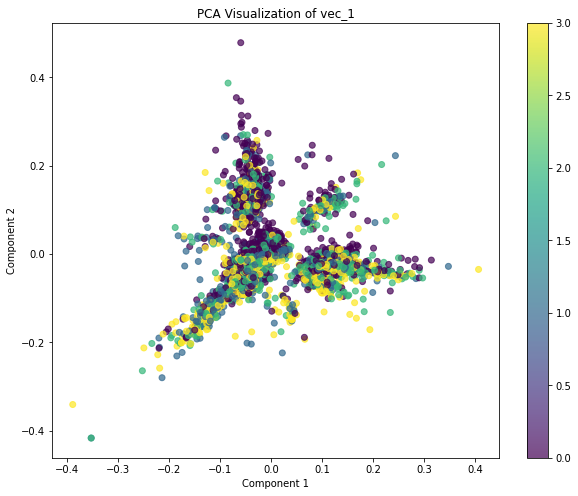

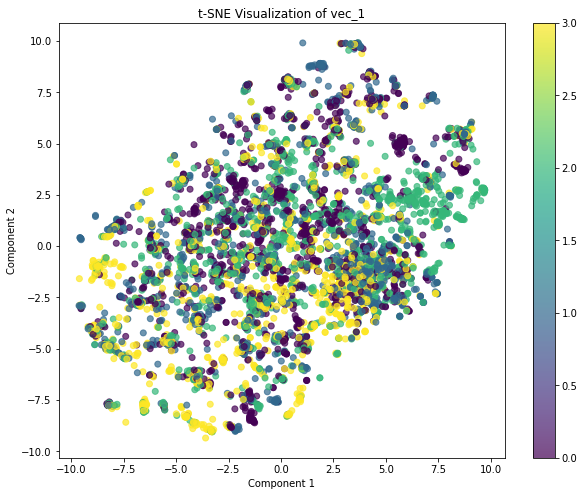

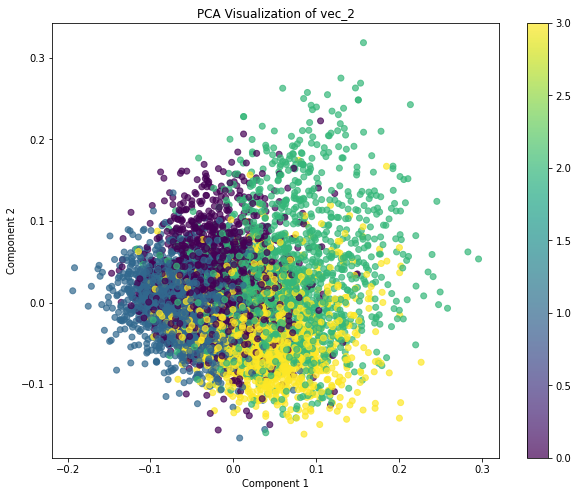

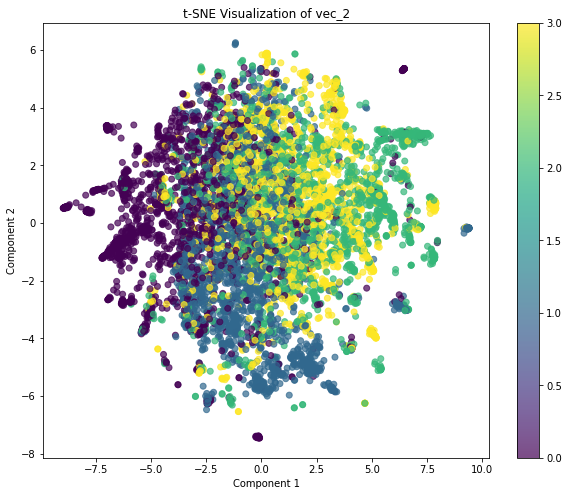

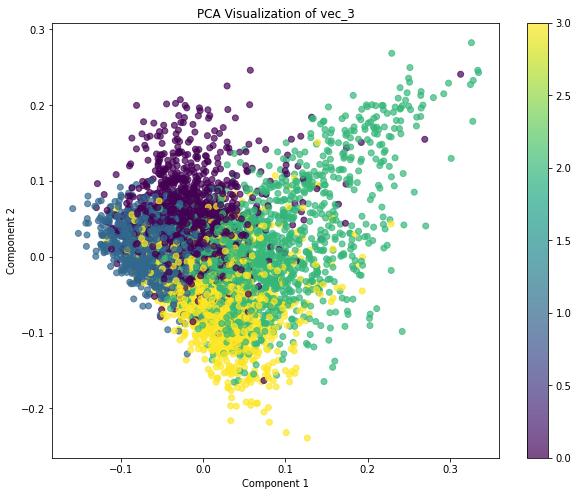

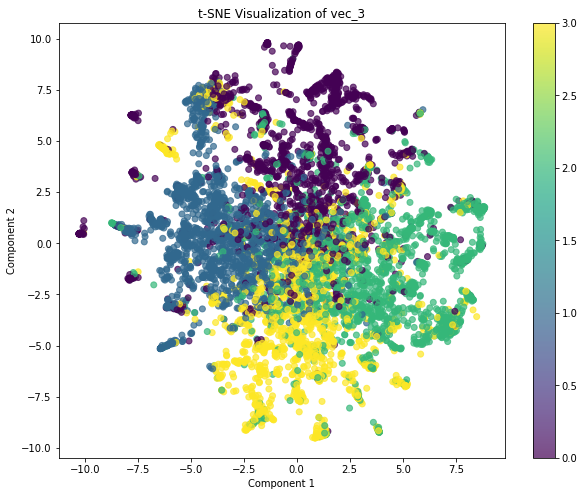

In [64]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# PCA Visualization
def visualize_embeddings(X, y, title, method='PCA'):
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300)
    
    reduced_data = reducer.fit_transform(X)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Visualize each embedding
for vec in ['vec_1', 'vec_2', 'vec_3']:
    X_test = np.array(test_data[vec].tolist())
    y_test = test_data['label'].values
    visualize_embeddings(X_test, y_test, f"PCA Visualization of {vec}")
    visualize_embeddings(X_test, y_test, f"t-SNE Visualization of {vec}", method='t-SNE')


In [65]:
from sklearn.metrics import accuracy_score

class KMeans:
    def __init__(self, n_clusters=4, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        n_samples, n_features = X.shape
        # Randomly initialize centroids
        np.random.seed(42)
        self.centroids = X[np.random.choice(n_samples, self.n_clusters, replace=False)]
        for i in range(self.max_iter):
            # Assign points to the nearest cluster
            self.labels_ = np.argmin(np.linalg.norm(X[:, None] - self.centroids, axis=2), axis=1)
            # Compute new centroids
            new_centroids = np.array([X[self.labels_ == k].mean(axis=0) for k in range(self.n_clusters)])
            # Check for convergence
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids

    def predict(self, X):
        return np.argmin(np.linalg.norm(X[:, None] - self.centroids, axis=2), axis=1)

def purity_score(y_true, y_pred):
    """Computes the purity score."""
    contingency_matrix = np.zeros((len(set(y_true)), len(set(y_pred))))
    for true, pred in zip(y_true, y_pred):
        contingency_matrix[true, pred] += 1
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

# Train and evaluate k-Means
for vec in ['vec_1', 'vec_2', 'vec_3']:
    print(f"Running k-Means on {vec}")
    X_train = np.array(train_split[vec].tolist())
    y_train = train_split['label'].values
    X_val = np.array(val_split[vec].tolist())
    y_val = val_split['label'].values

    kmeans = KMeans(n_clusters=4)
    kmeans.fit(X_train)

    val_preds = kmeans.predict(X_val)
    purity = purity_score(y_val, val_preds)
    print(f"Purity for {vec}: {purity}")


Running k-Means on vec_1
Purity for vec_1: 0.27993393889347645
Running k-Means on vec_2
Purity for vec_2: 0.34021469859620146
Running k-Means on vec_3
Purity for vec_3: 0.32452518579686207


In [66]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

def evaluate_agglomerative_clustering(X_train, y_train, X_val, y_val):
    # Fit Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=4)
    agg_clustering.fit(X_train)

    # Predict clusters for validation set
    val_preds = agg_clustering.fit_predict(X_val)

    # Evaluate
    purity = purity_score(y_val, val_preds)
    ari = adjusted_rand_score(y_val, val_preds)
    return purity, ari

# Evaluate Agglomerative Clustering for each embedding
for vec in ['vec_1', 'vec_2', 'vec_3']:
    print(f"Running Agglomerative Clustering on {vec}")
    X_train = np.array(train_split[vec].tolist())
    y_train = train_split['label'].values
    X_val = np.array(val_split[vec].tolist())
    y_val = val_split['label'].values

    purity, ari = evaluate_agglomerative_clustering(X_train, y_train, X_val, y_val)
    print(f"Purity for {vec}: {purity}")
    print(f"Adjusted Rand Index (ARI) for {vec}: {ari}")


Running Agglomerative Clustering on vec_1
Purity for vec_1: 0.29232039636663915
Adjusted Rand Index (ARI) for vec_1: 0.0030298163905509
Running Agglomerative Clustering on vec_2
Purity for vec_2: 0.36498761354252685
Adjusted Rand Index (ARI) for vec_2: 0.04167931054063502
Running Agglomerative Clustering on vec_3
Purity for vec_3: 0.29644921552436004
Adjusted Rand Index (ARI) for vec_3: 0.001817272895712962


Visualizing clusters for vec_1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


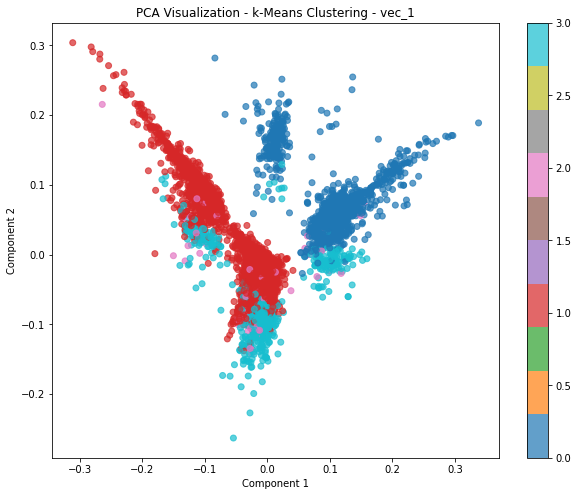

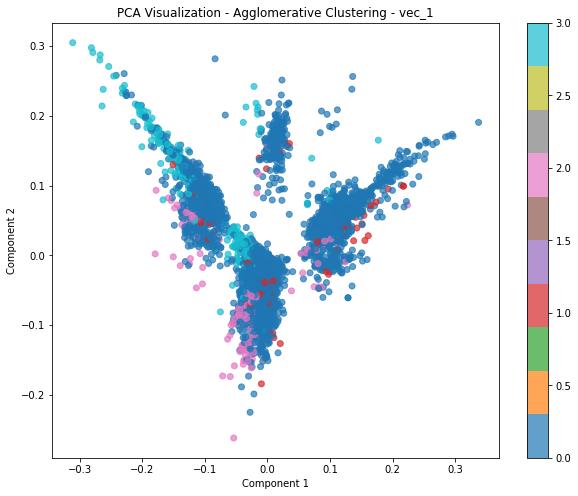

Visualizing clusters for vec_2


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


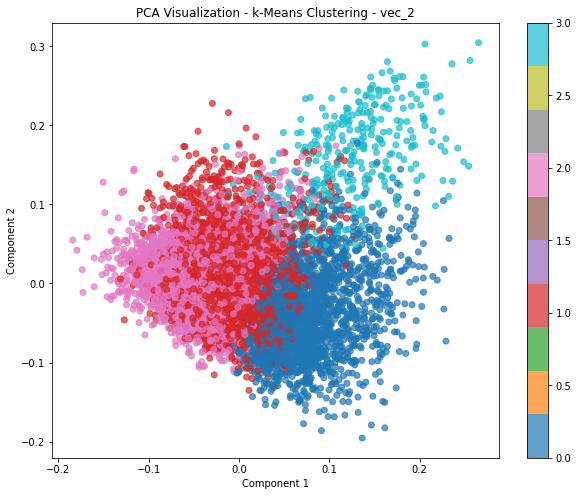

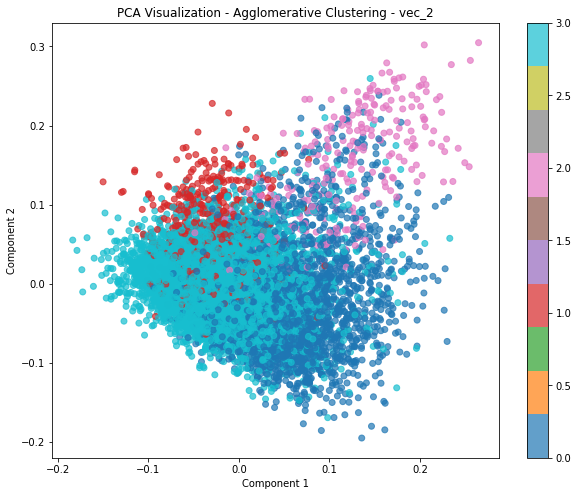

Visualizing clusters for vec_3


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


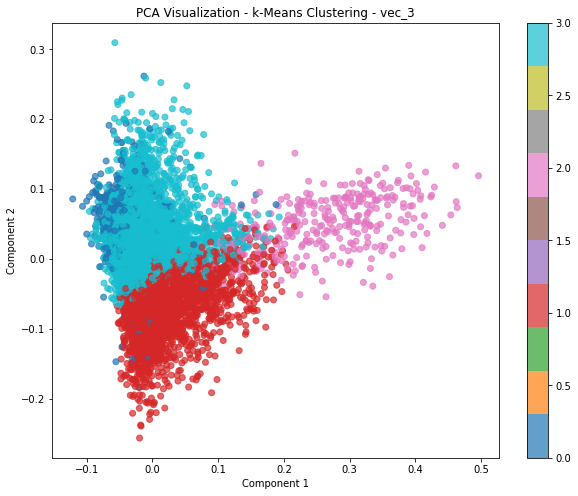

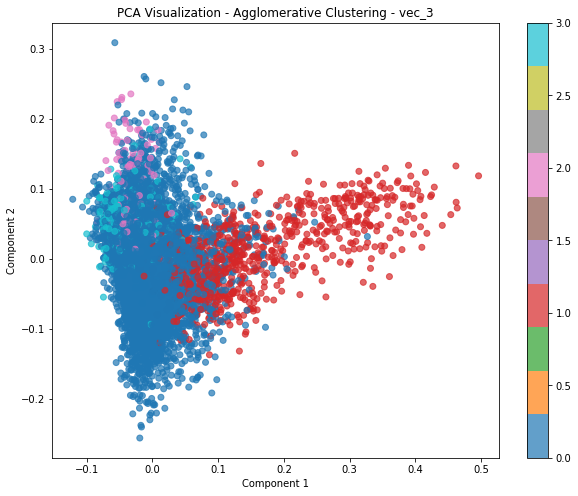

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_clusters(X, y_pred, title, method='PCA'):
    """Visualize clustering results."""
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)

    reduced_data = reducer.fit_transform(X)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title(f"{method} Visualization - {title}")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Visualize clusters for k-Means and Agglomerative Clustering
for vec in ['vec_1', 'vec_2', 'vec_3']:
    print(f"Visualizing clusters for {vec}")

    # Convert embedding to NumPy array
    X_train = np.array(train_split[vec].tolist())

    # K-Means Clustering
    kmeans_preds = KMeans(n_clusters=4, random_state=42).fit(X_train).predict(X_train)
    visualize_clusters(X_train, kmeans_preds, f"k-Means Clustering - {vec}", method='PCA')

    # Agglomerative Clustering
    agg_preds = AgglomerativeClustering(n_clusters=4).fit_predict(X_train)
    visualize_clusters(X_train, agg_preds, f"Agglomerative Clustering - {vec}", method='PCA')


In [98]:
import scrapy
import json

class ResearchGateSpider(scrapy.Spider):
    name = "researchgate"
    allowed_domains = ["researchgate.net"]
    start_urls = ["https://www.researchgate.net/publication/123456_Sample_Title"]

    visited_urls = set()
    articles = {}
    max_articles = 2000

    def parse(self, response):
        if len(self.articles) >= self.max_articles:
            return

        url = response.url
        if url in self.visited_urls:
            return
        self.visited_urls.add(url)

        try:
            article_id = url.split('/')[-2]
            title = response.css('.publication-title::text').get() or "No Title"
            abstract = response.css('.abstract-text::text').get() or "No Abstract"
            year = response.css('.publication-details span::text').get() or "No Year"
            authors = response.css('.authors-list .author-name::text').getall() or ["No Authors"]
            references = response.css('.reference a::attr(href)').getall()[:10]

            self.articles[article_id] = {
                'id': article_id,
                'title': title,
                'abstract': abstract,
                'year': year,
                'authors': authors,
                'references': references
            }

            print(f"Scraped article: {title}")
            for ref in references:
                if len(self.articles) < self.max_articles:
                    yield response.follow(ref, callback=self.parse)

        except Exception as e:
            self.logger.error(f"Error scraping {url}: {e}")

    def closed(self, reason):
        print(f"Scraped {len(self.articles)} articles.")
        with open('output.json', 'w') as outfile:
            json.dump(self.articles, outfile, indent=4)


In [93]:
import json
import numpy as np

def compute_pagerank(json_file, alpha=0.85, max_iter=100, tol=1e-6):
    # Load crawled data
    with open(json_file, 'r') as infile:
        articles = json.load(infile)

    # Create adjacency matrix
    article_ids = list(articles.keys())
    id_to_index = {article_id: i for i, article_id in enumerate(article_ids)}
    n = len(article_ids)
    adjacency_matrix = np.zeros((n, n))

    for article_id, details in articles.items():
        src_idx = id_to_index[article_id]
        for ref in details['references']:
            if ref in id_to_index:
                tgt_idx = id_to_index[ref]
                adjacency_matrix[src_idx, tgt_idx] = 1

    # Normalize adjacency matrix (row-wise)
    out_degree = adjacency_matrix.sum(axis=1)
    for i in range(n):
        if out_degree[i] > 0:
            adjacency_matrix[i] /= out_degree[i]

    # Initialize PageRank scores
    pagerank = np.ones(n) / n
    teleport = np.ones(n) / n

    for _ in range(max_iter):
        new_pagerank = alpha * np.dot(adjacency_matrix.T, pagerank) + (1 - alpha) * teleport
        if np.linalg.norm(new_pagerank - pagerank, ord=1) < tol:
            break
        pagerank = new_pagerank

    # Save PageRank scores
    pagerank_dict = {article_ids[i]: float(pagerank[i]) for i in range(n)}
    with open('PageRank.json', 'w') as outfile:
        json.dump(pagerank_dict, outfile, indent=4)

# Run PageRank
compute_pagerank('researchgate_crawler/output.json', alpha=0.85)


In [95]:
def rank_authors(json_file, pagerank_file):
    # Load crawled articles and PageRank scores
    with open(json_file, 'r') as infile:
        articles = json.load(infile)
    with open(pagerank_file, 'r') as infile:
        pagerank = json.load(infile)

    author_scores = {}

    for article_id, details in articles.items():
        score = pagerank.get(article_id, 0)
        for author in details['authors']:
            if author not in author_scores:
                author_scores[author] = 0
            author_scores[author] += score

    # Sort authors by cumulative scores
    ranked_authors = sorted(author_scores.items(), key=lambda x: x[1], reverse=True)

    # Save ranked authors
    with open('AuthorRank.json', 'w') as outfile:
        json.dump(ranked_authors, outfile, indent=4)

# Run Author Ranking
rank_authors('researchgate_crawler/output.json', 'PageRank.json')
